## Trend Example 1

In [1]:
import sys
import os

sys.path.append(
    os.path.abspath(
        os.path.join(os.path.dirname(os.path.realpath("__file__")), "..", "..")
    )
)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
from visualization.figure import Figure
import visualization.charts as charts

### Create fake data

In [5]:
rf = 0.04
np.random.seed(1)
mus = np.random.normal(loc=0.05, scale=0.02, size=5) + rf
sigmas = (mus - rf) / 0.3 + np.random.normal(loc=0.0, scale=0.01, size=5)

num_years = 10
num_months_per_year = 12
num_days_per_month = 21
num_days_per_year = num_months_per_year * num_days_per_month

rdf = pd.DataFrame(
    index=pd.date_range(
        start="2008-01-02",
        periods=num_years * num_months_per_year * num_days_per_month,
        freq="B",
    ),
    columns=["foo", "bar", "baz", "fake1", "fake2"],
)

for i, mu in enumerate(mus):
    sigma = sigmas[i]
    rdf.iloc[:, i] = np.random.normal(
        loc=mu / num_days_per_year,
        scale=sigma / np.sqrt(num_days_per_year),
        size=rdf.shape[0],
    )
pdf = np.cumprod(1 + rdf) * 100
test = pdf.reset_index(names="DATE")

In [6]:
import data_loader.yahoo_finance as yahoo_finance

client = yahoo_finance.YahooDataClient(
    ["AAPL", "MSFT", "GE", "MCD", "DIS", "APP"], max_workers=10
)

all_financial_annual = client.get_financials(annual=False, statement_type="financial")
ebit = all_financial_annual.pivot(
    index=["REPORT_DATE"], columns="TICKER", values="EBIT"
).dropna()
prices = client.get_prices(start_date="2025-01-01")
close = prices.pivot(index=["DATE"], columns="TICKER", values="CLOSE")

client = yahoo_finance.YahooDataClient(["AAPL"], max_workers=10)

prices_aapl = client.get_prices(start_date="2025-01-01")

aapl_fin = all_financial_annual[all_financial_annual["TICKER"] == "AAPL"]
aapl_fin = aapl_fin[aapl_fin["REPORT_DATE"] == pd.to_datetime("2025-09-30")]

aapl_fin.loc[
    :,
    [
        "COST_OF_REVENUE",
        "OPERATING_EXPENSE",
        "TAX_PROVISION",
    ],
] = -aapl_fin.loc[
    :,
    [
        "COST_OF_REVENUE",
        "OPERATING_EXPENSE",
        "TAX_PROVISION",
    ],
]

2025-12-06 18:57:46 - INFO - Loading Company Financial
2025-12-06 18:57:47 - INFO - Loading Prices
2025-12-06 18:57:47 - INFO - Loading Prices


In [7]:
l = charts.Line(pdf)
l.create(x="index", y=["foo", "bar"], width=2, mode="lines")
l.quick_styling(
    x_title="Date",
    y_title="Price",
    selector_buttons=False,
    rangeslider=True,
)
a = charts.Area(pdf)
a.create(x="index", y=["fake1", "fake2"])
a.quick_styling(
    x_title="Date", y_title="Price", selector_buttons=False, rangeslider=True
)
a.add_selector_buttons(x=0.5)

h = charts.Heatmap(pdf.pct_change().dropna().cov())
h.create(showscale=False)


hist = charts.Histogram(pdf.pct_change().dropna())
hist.create(
    y=["foo", "bar"],
    histnorm="probability",
)  # cumulative=True)
hist.quick_styling(
    y_title="Count",
    selector_buttons=False,
    rangeslider=False,
)
hist.legend(show=False)


pie = charts.Pie(ebit.T)
pie.create(x="index", y=pd.to_datetime("2025-09-30"), hole=0.3, textinfo="percent")

bar = charts.Bar(ebit)
bar.create(x="index", y=ebit.columns, barmode="group")

candle = charts.Candlestick(prices_aapl)
candle.create(x="DATE", open="OPEN", high="HIGH", low="LOW", close="CLOSE")
# candle.quick_styling(x_title="Date", rangeslider=True)
candle.add_selector_buttons(
    bgcolor="rgba(240,240,240,0.85)",
    activecolor="#1f77b4",
    bordercolor="rgba(100,100,100,0.2)",
    font_size=12,
    font_color="#222",
    x=0.0,
    xanchor="left",
    y=1.02,
    yanchor="top",
)
candle.legend(show=False)

line = charts.Line(close)
line.create(x="index", y=close.columns, width=2, mode="lines")
line.quick_styling(
    x_title="Date",
    y_title="Price",
    selector_buttons=False,
    rangeslider=True,
)

box = charts.Boxplot(close.pct_change().dropna())
box.create(y=["AAPL", "MSFT"], boxpoints="outliers", jitter=0.03)
box.legend(show=False)

ind = charts.Indicator(ebit)
ind.create(
    ebit.iloc[-1].values[0],
    title="EBIT",
    mode="gauge+number+delta",
    delta_reference=ebit["AAPL"].mean(),
    number_format="{:.2f}",
    gauge=True,
    # gauge_shape="bullet",
    gauge_steps=[
        {"range": [0, 20000000000], "color": "lightgray"},
        {"range": [20000000000, 40000000000], "color": "gray"},
    ],
    threshold_value=45000000000,
)

waterfall = charts.Waterfall(
    aapl_fin[
        [
            "TOTAL_REVENUE",
            "COST_OF_REVENUE",
            "OPERATING_EXPENSE",
            "TAX_PROVISION",
            "NET_INCOME",
        ]
    ]
)

waterfall.create(
    x=[
        "TOTAL_REVENUE",
        "COST_OF_REVENUE",
        "OPERATING_EXPENSE",
        "TAX_PROVISION",
        "NET_REVENUE",
    ],
    y=[
        "TOTAL_REVENUE",
        "COST_OF_REVENUE",
        "OPERATING_EXPENSE",
        "TAX_PROVISION",
        "TOTAL",
    ],
)

<Chart id=8421bd30-eb17-49b3-afa0-56fd94e44ad9 traces=1 layout_updates=0>

In [ ]:
c = Figure(rows=2, cols=2, column_widths=[0.3, 0.7], vertical_spacing=0.3)
# c.add_chart(candle, row=1, col=1, colspan=2)
# c.add_chart(pie, row=2, col=1)
# c.add_chart(bar, row=2, col=2)
c.add_chart(waterfall, row=2, col=2)
c.add_chart(line, row=1, col=1, colspan=2)
# c.add_chart(box, row=2, col=1)
c.add_chart(ind, row=2, col=1)
c.layout(title="AAPL", height=700, showlegend=True)
c.show()

In [9]:
tickers = [
    "AAPL",
    "MSFT",
    "AMZN",
    "GOOGL",
    "TSLA",
    "BRK-B",
    "JPM",
    "JNJ",
    "V",
    "WMT",
    "PG",
    "UNH",
    "MA",
    "HD",
    "DIS",
    "PYPL",
    "BAC",
    "VZ",
    "CMCSA",
    "ADBE",
    "NFLX",
    "KO",
    "PFE",
    "NKE",
    "MRK",
    "T",
    "ABBV",
    "INTC",
    "CRM",
    "PEP",
    "CSCO",
    "XOM",
    "ORCL",
    "CVX",
    "ABT",
    "QCOM",
    "MCD",
    "ACN",
    "IBM",
    "LLY",
    "AVGO",
    "COST",
    "MDT",
    "DHR",
    "HON",
    "WFC",
    "BMY",
    "TXN",
    "SBUX",
    "C",
    "AMGN",
    "AMAT",
    "UPS",
    "RTX",
    "GE",
    "CAT",
    "BKNG",
    "SPGI",
    "MO",
    "LIN",
    "TMO",
    "GILD",
    "BLK",
    "USB",
    "DE",
    "SCHW",
    "F",
    "PLD",
    "MDLZ",
    "SYK",
    "ADP",
    "CI",
    "ISRG",
    "ZTS",
    "COP",
    "SO",
    "EXC",
    "DUK",
    "SPG",
    "VRTX",
    "ORLY",
    "APD",
    "EQIX",
    "NOC",
    "TJX",
    "MMC",
    "ITW",
    "BSX",
    "TMUS",
    "KMB",
    "HCA",
    "MU",
    "FIS",
    "EMR",
    "AON",
    "PNC",
    "CL",
    "WM",
    "F",
    "D",
    "AMT",
    "PGR",
    "ROK",
]

client = yahoo_finance.YahooDataClient(tickers)
prices = client.get_prices(start_date="2023-01-01")

2025-12-06 18:57:48 - INFO - Loading Prices


In [10]:
prices["YEAR"] = pd.to_datetime(prices["DATE"]).dt.year

# Group by ticker and year
result = (
    prices.groupby(["TICKER", "YEAR"])
    .apply(
        lambda x: pd.Series(
            {"FULL_YEAR_RETURN": (x["ADJ_CLOSE"].iloc[-1]) / x["ADJ_CLOSE"].iloc[0] - 1}
        )
    )
    .reset_index()
)
result = result.pivot(columns="YEAR", index="TICKER", values="FULL_YEAR_RETURN")
result[2025] = (result[2025] > 0.1).astype(int)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from visualization.machine_learning import KNNPlotter


# Load and split data
X, y = result.iloc[:, :2].values, result.iloc[:, 2].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y.astype(str), test_size=0.25, random_state=0
)

# Create classifier, run predictions on grid
clf = KNeighborsClassifier(5, weights="uniform")
clf.fit(X_train, y_train)

knn = KNNPlotter(
    clf=clf, x=X, x_test=X_test, x_train=X_train, y_test=y_test, y_train=y_train
)
knn.plot(layout={"title": "10% Return Prediction", "width": 900})

In [12]:
raise NotImplementedError()

NotImplementedError: 

In [ ]:
c = Figure(
    rows=2,
    cols=2,
    column_widths=[0.3, 0.7],
    vertical_spacing=0.25,
)
c.add_chart(l, row=1, col=1)
c.add_chart(a, row=1, col=2)
c.add_chart(hist, row=2, col=1)
c.add_chart(h, row=2, col=2)
c.layout(title="Fake Data", height=900)
c.show()

In [ ]:
c = Figure(rows=1, cols=1)
c.add_chart(l, row=1, col=1)
c.add_chart(a, row=1, col=1)
c.layout(title="Fake Data")
c.show()

### Create Trend signal over the last 12 months

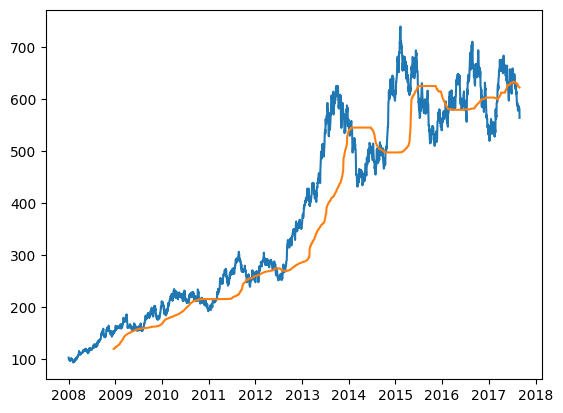

In [ ]:
sma = pdf.rolling(window=num_days_per_month * 12, center=False).median().shift(1)
plt.plot(pdf.index, pdf["foo"])
plt.plot(sma.index, sma["foo"])
plt.show()

In [ ]:
# target weights
trend = sma.copy()
trend[pdf > sma] = True
trend[pdf <= sma] = False
trend[sma.isnull()] = False
trend.tail()

/var/folders/sc/dbchfm_s3kv6pz1zshqjcn640000gn/T/ipykernel_12889/599213171.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  trend[pdf > sma] = True


,foo,bar,baz,fake1,fake2
2017-08-23,False,True,True,True,True
2017-08-24,False,True,True,True,True
2017-08-25,False,True,True,True,True
2017-08-28,False,True,True,True,True
2017-08-29,False,True,True,True,True


Compare EW and 1/vol

Both strategies rebalance daily using trend with 1 day lag and weights limited to 40%.

In [ ]:
from bt.core import Strategy
from bt.algos.flow import RunDaily
from bt.algos.selection import SelectWhere
from bt.algos.weighting import WeighInvVol, WeighEqually, LimitWeights
from bt.algos.portfolio_ops import Rebalance
from bt.engine import Backtest
import bt

In [ ]:
tsmom_invvol_strat = Strategy(
    "tsmom_invvol",
    [
        RunDaily(),
        SelectWhere(trend),
        WeighInvVol(),
        LimitWeights(limit=0.5),
        Rebalance(),
    ],
)

tsmom_ew_strat = Strategy(
    "tsmom_ew",
    [
        RunDaily(),
        SelectWhere(trend),
        WeighEqually(),
        LimitWeights(limit=0.5),
        Rebalance(),
    ],
)

In [ ]:
# create and run
tsmom_invvol_bt = Backtest(
    tsmom_invvol_strat,
    pdf,
    initial_capital=50000000.0,
    commissions=lambda q, p: max(100, abs(q) * 0.0021),
    integer_positions=False,
    progress_bar=True,
)
tsmom_invvol_res = bt.run(tsmom_invvol_bt)

tsmom_ew_bt = Backtest(
    tsmom_ew_strat,
    pdf,
    initial_capital=50000000.0,
    commissions=lambda q, p: max(100, abs(q) * 0.0021),
    integer_positions=False,
    progress_bar=True,
)
tsmom_ew_res = bt.run(tsmom_ew_bt)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


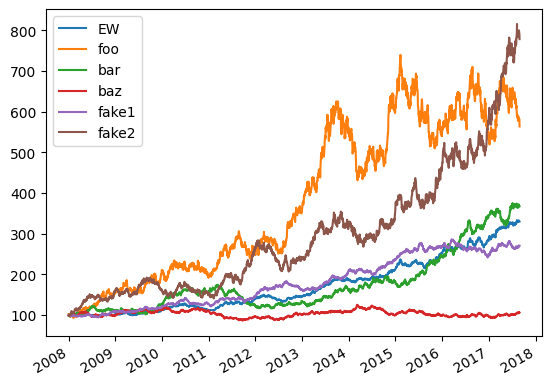

In [ ]:
ax = plt.subplot()
ax.plot(tsmom_ew_res.prices.index, tsmom_ew_res.prices, label="EW")
pdf.plot(ax=ax)

ax.legend()
plt.legend()
plt.show()

In [ ]:
tsmom_ew_res.stats

,tsmom_ew
start,2008-01-01 00:00:00
end,2017-08-29 00:00:00
rf,0.0
total_return,2.300043
cagr,0.131571
max_drawdown,-0.128013
calmar,1.027792
mtd,0.017549
three_month,0.040739
six_month,0.083428
